In [5]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings - JNS style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Project imports
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from src.config import (
    PROCESSED_DATA_DIR, TABLES_DIR, FIGURES_DIR,
    TN_CONFIG, JNS, ensure_directories
)

ensure_directories()
print(f"Data dir: {PROCESSED_DATA_DIR}")


Data dir: /Users/dhirajpangal/Library/Mobile Documents/com~apple~CloudDocs/Desktop/RESEARCH/STANFORD/Cosmos/trigeminalneuralgia-cosmos/analysis/outputs/data


In [6]:
# Load cleaned census region data
df_meds = pd.read_csv(PROCESSED_DATA_DIR / 'census_medications_clean.csv')
df_procs = pd.read_csv(PROCESSED_DATA_DIR / 'census_procedures_clean.csv')
df_cross = pd.read_csv(PROCESSED_DATA_DIR / 'census_meds_procedures_clean.csv')

print("Loaded census region datasets:")
print(f"  Medications: {df_meds.shape} - {df_meds['total'].sum():,} patients")
print(f"  Procedures: {df_procs.shape}")
print(f"  Cross-tab: {df_cross.shape}")
print(f"  Regions: {df_meds['census_region'].nunique()}")

# Define column lists
MED_COLS = ['carbamazepine_oxcarbazepine', 'gabapentin', 'pregabalin', 
            'baclofen', 'lamotrigine', 'none_of_above']
PROC_COLS = ['mvd', 'srs', 'rhizotomy', 'botox', 'none_of_above']

# Display names
MED_DISPLAY = {
    'carbamazepine_oxcarbazepine': 'Carbamazepine/Oxcarbazepine',
    'gabapentin': 'Gabapentin',
    'pregabalin': 'Pregabalin',
    'baclofen': 'Baclofen',
    'lamotrigine': 'Lamotrigine',
    'none_of_above': 'No TN Medication'
}

PROC_DISPLAY = {
    'mvd': 'MVD',
    'srs': 'SRS (Radiosurgery)',
    'rhizotomy': 'Rhizotomy',
    'botox': 'Botox',
    'none_of_above': 'No Procedure'
}

df_meds


Loaded census region datasets:
  Medications: (9, 8) - 302,971 patients
  Procedures: (9, 7)
  Cross-tab: (54, 8)
  Regions: 9


,census_region,carbamazepine_oxcarbazepine,baclofen,gabapentin,lamotrigine,pregabalin,none_of_above,total
0,New England,7391,2691,9297,1225,2465,5663,19802
1,Middle Atlantic,16121,6210,19565,2709,5497,9607,39021
2,East North Central,25508,10219,29935,4083,9391,13900,60044
3,West North Central,9035,3080,10163,1436,3164,4408,20236
4,South Atlantic,30193,12154,37744,4695,12627,15805,71862
5,East South Central,7314,2754,7943,1009,2841,3090,15447
6,West South Central,14969,5453,17969,1944,6050,6042,32130
7,Mountain,7172,2950,8518,1385,3044,4380,17959
8,Pacific,10038,4052,13196,1578,4095,6946,26470


In [7]:
# Statistical helper functions
def format_pvalue(p):
    """Format p-value: 3 decimals or <0.001"""
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

def z_test_proportion(x, n, p0):
    """
    Z-test for comparing observed proportion to reference proportion.
    x: number of successes, n: sample size, p0: reference proportion
    """
    p_hat = x / n
    se = np.sqrt(p0 * (1 - p0) / n)
    if se == 0:
        return 0, 1.0
    z = (p_hat - p0) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value

def proportion_ci(x, n, confidence=0.95):
    """Wilson score interval for proportion."""
    if n == 0:
        return 0, 0
    p_hat = x / n
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2 * n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n)) / n) / denominator
    return max(0, center - margin) * 100, min(1, center + margin) * 100

print("✓ Statistical functions defined")


✓ Statistical functions defined


In [8]:
# Calculate national totals
NATIONAL_TOTAL = df_meds['total'].sum()
print(f"Total TN patients nationally: {NATIONAL_TOTAL:,}")

# National medication rates
print("\n" + "=" * 70)
print("NATIONAL MEDICATION UTILIZATION RATES")
print("=" * 70)

med_data = []
for col in MED_COLS:
    n = df_meds[col].sum()
    rate = n / NATIONAL_TOTAL * 100
    ci_low, ci_high = proportion_ci(n, NATIONAL_TOTAL)
    med_data.append({
        'Medication': MED_DISPLAY.get(col, col),
        'N': f"{n:,}",
        'Rate (%)': f"{rate:.1f}",
        '95% CI': f"({ci_low:.1f}-{ci_high:.1f})"
    })

df_med_national = pd.DataFrame(med_data)
print(df_med_national.to_string(index=False))

# National procedure rates
print("\n" + "=" * 70)
print("NATIONAL PROCEDURE UTILIZATION RATES")
print("=" * 70)

proc_data = []
for col in PROC_COLS:
    n = df_procs[col].sum()
    rate = n / NATIONAL_TOTAL * 100
    ci_low, ci_high = proportion_ci(n, NATIONAL_TOTAL)
    proc_data.append({
        'Procedure': PROC_DISPLAY.get(col, col),
        'N': f"{n:,}",
        'Rate (%)': f"{rate:.2f}",
        '95% CI': f"({ci_low:.2f}-{ci_high:.2f})"
    })

df_proc_national = pd.DataFrame(proc_data)
print(df_proc_national.to_string(index=False))


Total TN patients nationally: 302,971

NATIONAL MEDICATION UTILIZATION RATES
                 Medication       N Rate (%)      95% CI
Carbamazepine/Oxcarbazepine 127,741     42.2 (42.0-42.3)
                 Gabapentin 154,330     50.9 (50.8-51.1)
                 Pregabalin  49,174     16.2 (16.1-16.4)
                   Baclofen  49,563     16.4 (16.2-16.5)
                Lamotrigine  20,064      6.6   (6.5-6.7)
           No TN Medication  69,841     23.1 (22.9-23.2)

NATIONAL PROCEDURE UTILIZATION RATES
         Procedure       N Rate (%)        95% CI
               MVD   4,072     1.34   (1.30-1.39)
SRS (Radiosurgery)   1,752     0.58   (0.55-0.61)
         Rhizotomy   2,937     0.97   (0.94-1.00)
             Botox   2,785     0.92   (0.89-0.95)
      No Procedure 279,631    92.30 (92.20-92.39)


In [9]:
# Calculate medication rates by region
print("=" * 80)
print("MEDICATION RATES BY CENSUS REGION")
print("=" * 80)

# Create rate table
med_rate_data = []
for _, row in df_meds.iterrows():
    region = row['census_region']
    total = row['total']
    entry = {'Region': region, 'N': f"{total:,}"}
    
    for col in MED_COLS:
        rate = row[col] / total * 100
        entry[MED_DISPLAY.get(col, col)] = f"{rate:.1f}%"
    
    med_rate_data.append(entry)

df_med_rates = pd.DataFrame(med_rate_data)
print(df_med_rates.to_string(index=False))


MEDICATION RATES BY CENSUS REGION
            Region      N Carbamazepine/Oxcarbazepine Gabapentin Pregabalin Baclofen Lamotrigine No TN Medication
       New England 19,802                       37.3%      46.9%      12.4%    13.6%        6.2%            28.6%
   Middle Atlantic 39,021                       41.3%      50.1%      14.1%    15.9%        6.9%            24.6%
East North Central 60,044                       42.5%      49.9%      15.6%    17.0%        6.8%            23.1%
West North Central 20,236                       44.6%      50.2%      15.6%    15.2%        7.1%            21.8%
    South Atlantic 71,862                       42.0%      52.5%      17.6%    16.9%        6.5%            22.0%
East South Central 15,447                       47.3%      51.4%      18.4%    17.8%        6.5%            20.0%
West South Central 32,130                       46.6%      55.9%      18.8%    17.0%        6.1%            18.8%
          Mountain 17,959                       39.9% 

In [10]:
# Calculate procedure rates by region
print("=" * 80)
print("PROCEDURE RATES BY CENSUS REGION")
print("=" * 80)

proc_rate_data = []
for _, row in df_procs.iterrows():
    region = row['census_region']
    total = row['total']
    entry = {'Region': region, 'N': f"{total:,}"}
    
    for col in PROC_COLS:
        rate = row[col] / total * 100
        entry[PROC_DISPLAY.get(col, col)] = f"{rate:.2f}%"
    
    proc_rate_data.append(entry)

df_proc_rates = pd.DataFrame(proc_rate_data)
print(df_proc_rates.to_string(index=False))


PROCEDURE RATES BY CENSUS REGION
            Region      N   MVD SRS (Radiosurgery) Rhizotomy Botox No Procedure
       New England 18,548 0.94%              1.57%     0.65% 0.73%       96.37%
   Middle Atlantic 37,678 1.20%              0.55%     1.25% 0.92%       96.37%
East North Central 57,279 1.05%              0.18%     1.11% 1.23%       96.65%
West North Central 19,402 1.23%              0.54%     0.89% 1.10%       96.54%
    South Atlantic 69,452 1.62%              0.82%     0.92% 0.83%       96.01%
East South Central 15,114 1.02%              0.64%     0.48% 0.48%       97.52%
West South Central 31,031 1.69%              0.55%     1.42% 0.76%       95.84%
          Mountain 17,247 1.36%              0.88%     0.82% 1.59%       95.55%
           Pacific 24,753 2.29%              0.25%     0.98% 0.91%       95.81%


In [11]:
# Chi-square tests for regional treatment preferences
print("=" * 80)
print("CHI-SQUARE TESTS: Regional Treatment Preferences")
print("=" * 80)

# Test 1: Medication preferences (excluding 'none_of_above')
med_cols_chi2 = [c for c in MED_COLS if c != 'none_of_above']
med_contingency = df_meds.set_index('census_region')[med_cols_chi2]

print("\n1. MEDICATION PREFERENCES BY REGION")
print("-" * 60)
print("H0: Regions have the same distribution of medication preferences")
print("H1: At least one region differs in medication preferences\n")

chi2_med, p_med, dof_med, expected_med = stats.chi2_contingency(med_contingency)

print(f"Contingency table shape: {med_contingency.shape}")
print(f"Chi-Square statistic: {chi2_med:.1f}")
print(f"Degrees of freedom: {dof_med}")
print(f"P-value: {format_pvalue(p_med)}")
print(f"Result: {'SIGNIFICANT - Regions differ in medication preferences' if p_med < 0.05 else 'Not significant'}")

# Test 2: Procedure preferences (excluding 'none_of_above')
proc_cols_chi2 = [c for c in PROC_COLS if c != 'none_of_above']
proc_contingency = df_procs.set_index('census_region')[proc_cols_chi2]

print("\n2. SURGICAL PROCEDURE PREFERENCES BY REGION")
print("-" * 60)
print("H0: Regions have the same distribution of surgical preferences")
print("H1: At least one region differs in surgical preferences\n")

chi2_proc, p_proc, dof_proc, expected_proc = stats.chi2_contingency(proc_contingency)

print(f"Contingency table shape: {proc_contingency.shape}")
print(f"Chi-Square statistic: {chi2_proc:.1f}")
print(f"Degrees of freedom: {dof_proc}")
print(f"P-value: {format_pvalue(p_proc)}")
print(f"Result: {'SIGNIFICANT - Regions differ in surgical preferences' if p_proc < 0.05 else 'Not significant'}")


CHI-SQUARE TESTS: Regional Treatment Preferences

1. MEDICATION PREFERENCES BY REGION
------------------------------------------------------------
H0: Regions have the same distribution of medication preferences
H1: At least one region differs in medication preferences

Contingency table shape: (9, 5)
Chi-Square statistic: 637.2
Degrees of freedom: 32
P-value: <0.001
Result: SIGNIFICANT - Regions differ in medication preferences

2. SURGICAL PROCEDURE PREFERENCES BY REGION
------------------------------------------------------------
H0: Regions have the same distribution of surgical preferences
H1: At least one region differs in surgical preferences

Contingency table shape: (9, 4)
Chi-Square statistic: 1090.1
Degrees of freedom: 24
P-value: <0.001
Result: SIGNIFICANT - Regions differ in surgical preferences


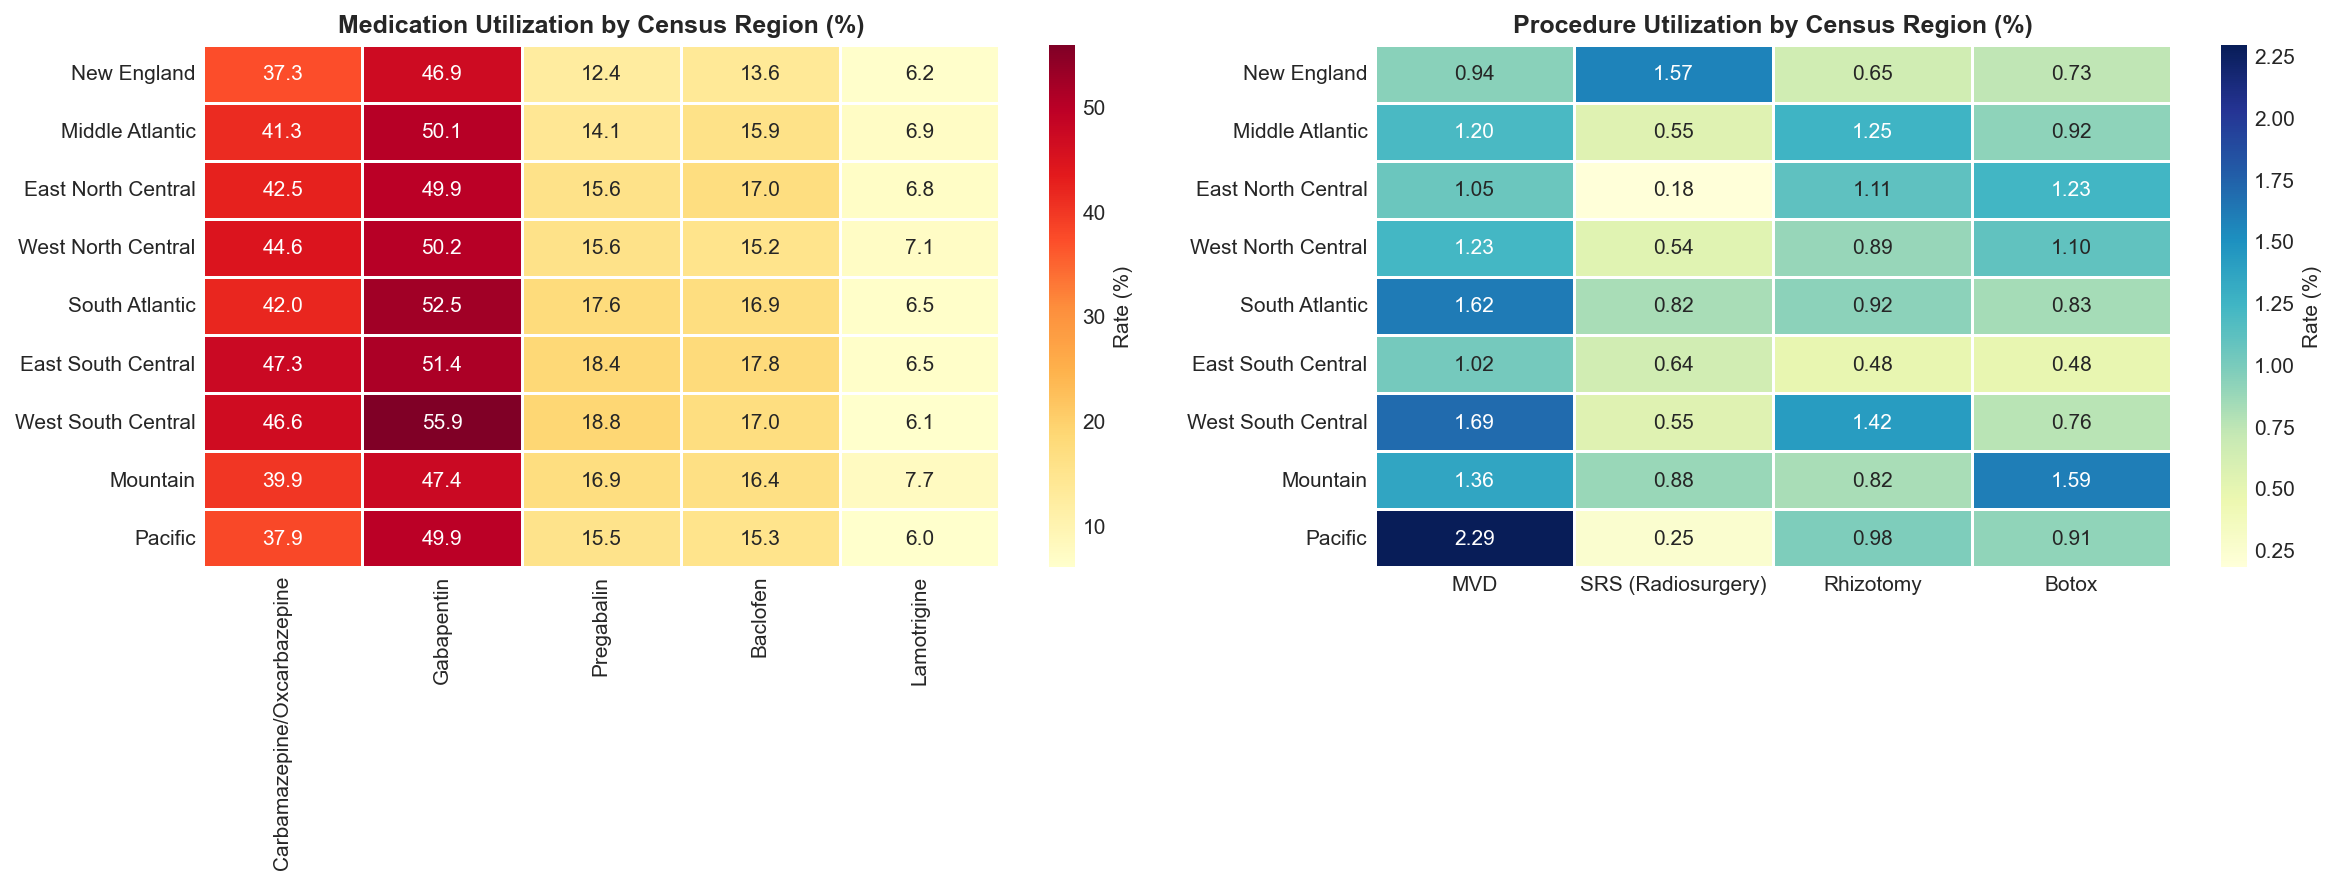

✓ Saved: census_treatment_heatmaps.png


In [12]:
# Heatmap of medication rates by region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Medication heatmap
ax1 = axes[0]
med_rates_matrix = df_meds.set_index('census_region')[med_cols_chi2].copy()
for col in med_cols_chi2:
    med_rates_matrix[col] = med_rates_matrix[col] / df_meds.set_index('census_region')['total'] * 100

med_rates_matrix.columns = [MED_DISPLAY.get(c, c) for c in med_cols_chi2]
sns.heatmap(med_rates_matrix, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1,
            cbar_kws={'label': 'Rate (%)'}, linewidths=0.5)
ax1.set_title('Medication Utilization by Census Region (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Procedure heatmap
ax2 = axes[1]
proc_rates_matrix = df_procs.set_index('census_region')[proc_cols_chi2].copy()
for col in proc_cols_chi2:
    proc_rates_matrix[col] = proc_rates_matrix[col] / df_procs.set_index('census_region')['total'] * 100

proc_rates_matrix.columns = [PROC_DISPLAY.get(c, c) for c in proc_cols_chi2]
sns.heatmap(proc_rates_matrix, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax2,
            cbar_kws={'label': 'Rate (%)'}, linewidths=0.5)
ax2.set_title('Procedure Utilization by Census Region (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'census_treatment_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: census_treatment_heatmaps.png")


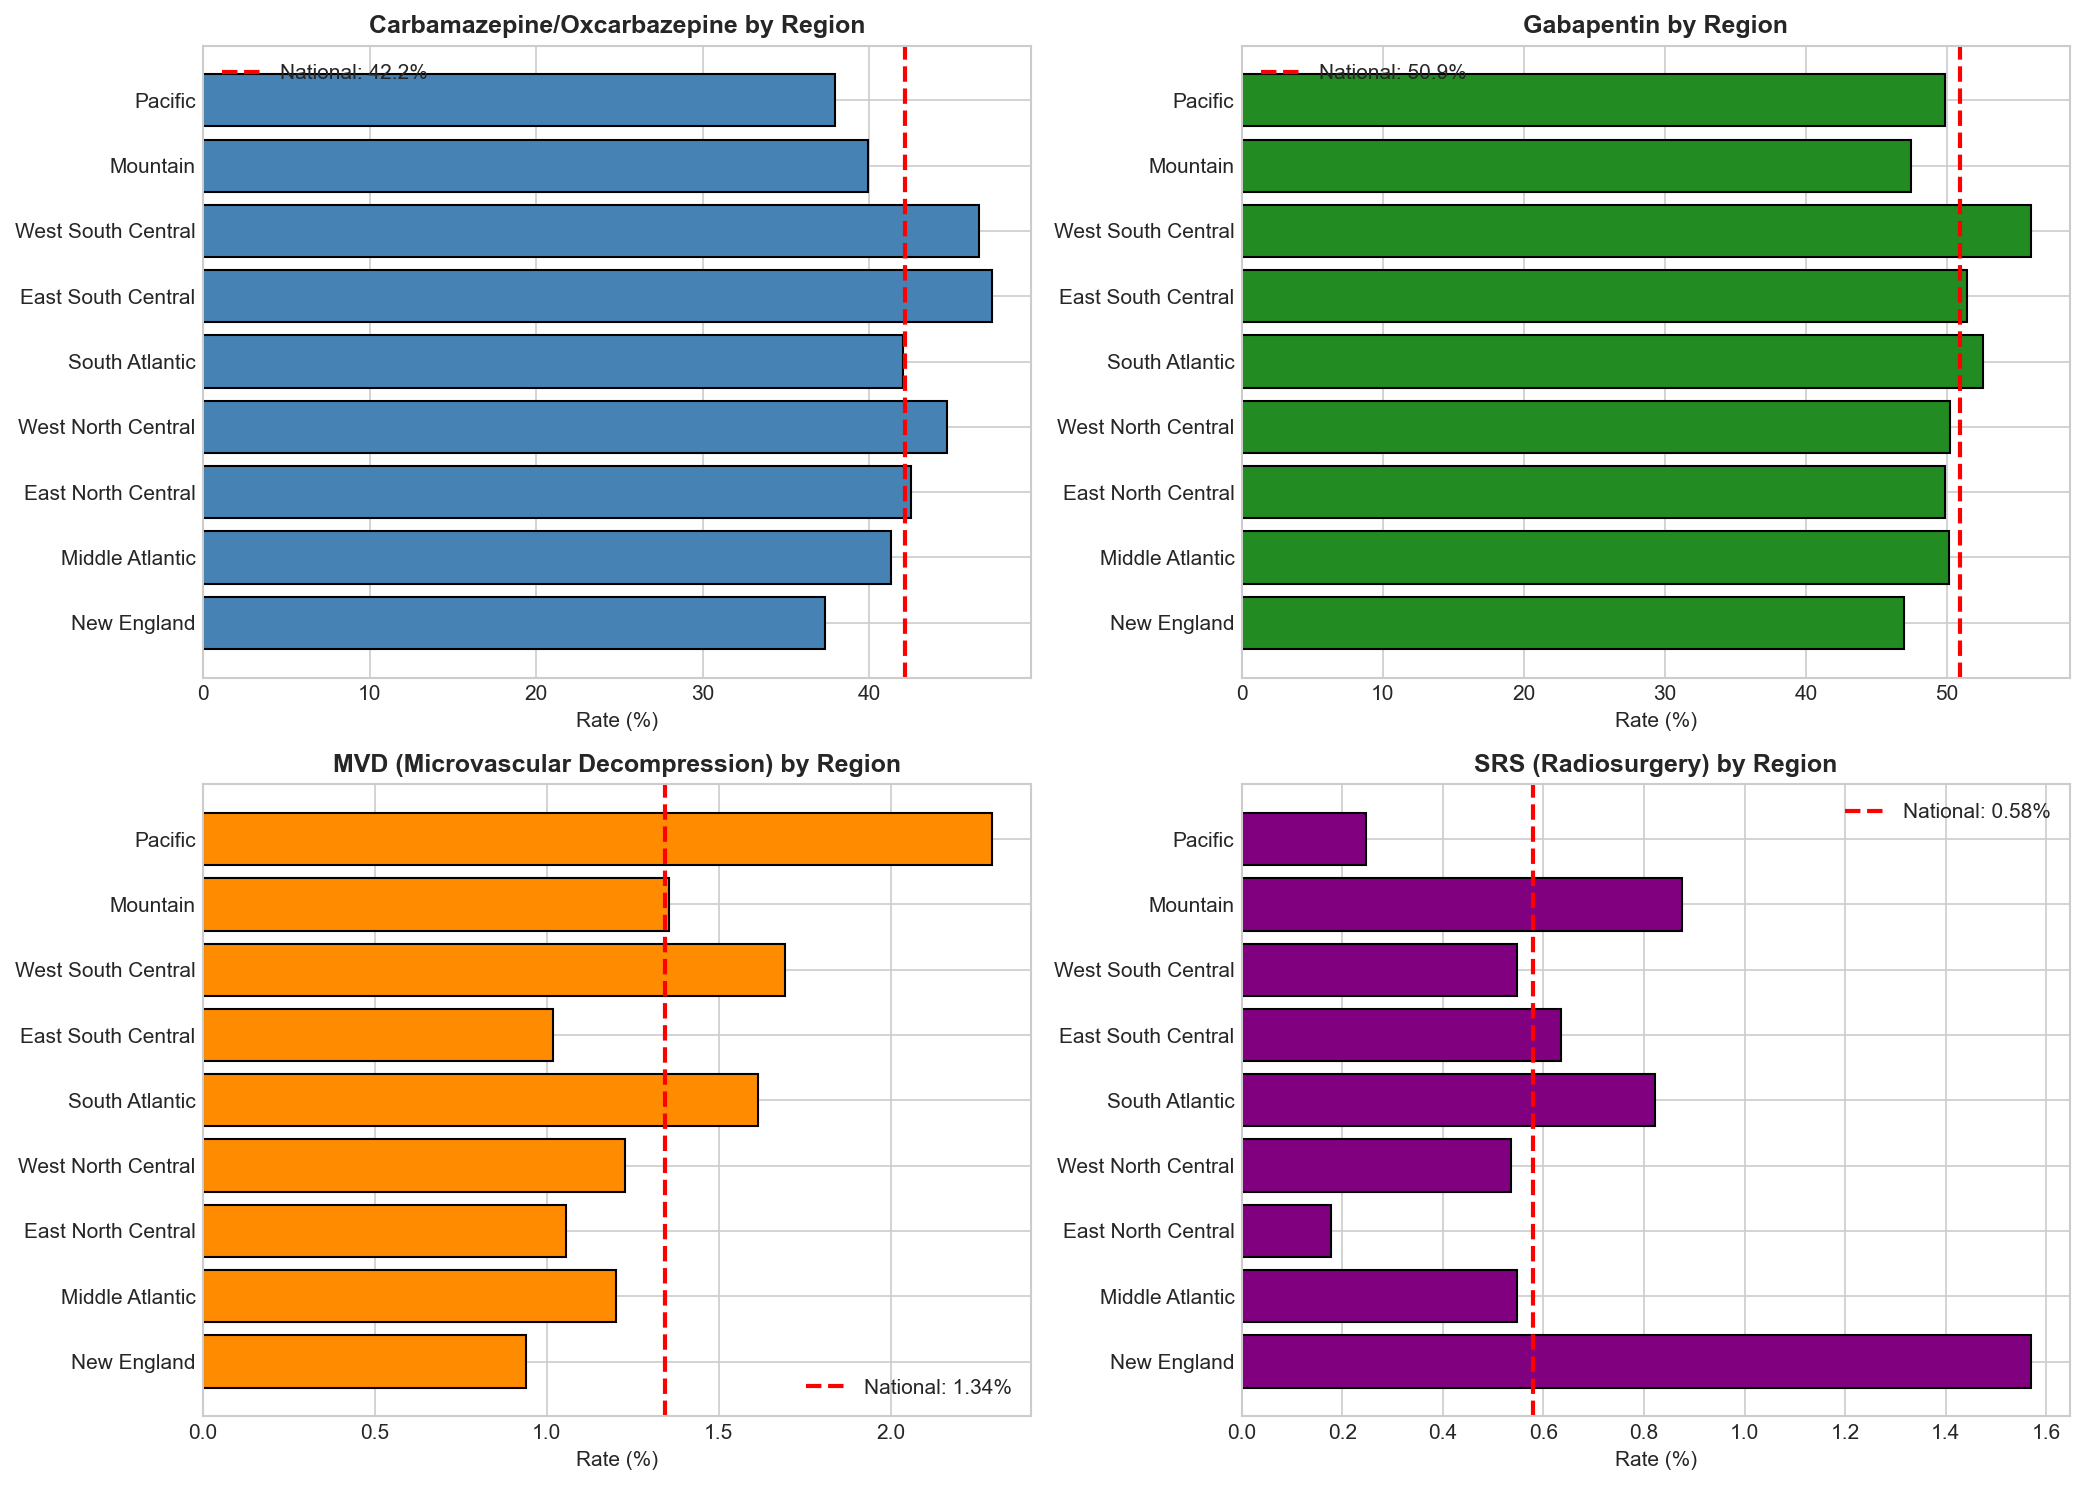

✓ Saved: census_regional_comparisons.png


In [13]:
# Bar chart comparing regions for key treatments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Carbamazepine rates by region
ax1 = axes[0, 0]
carb_rates = (df_meds['carbamazepine_oxcarbazepine'] / df_meds['total'] * 100).values
national_carb = df_meds['carbamazepine_oxcarbazepine'].sum() / NATIONAL_TOTAL * 100
bars1 = ax1.barh(df_meds['census_region'], carb_rates, color='steelblue', edgecolor='black')
ax1.axvline(national_carb, color='red', linestyle='--', linewidth=2, label=f'National: {national_carb:.1f}%')
ax1.set_xlabel('Rate (%)')
ax1.set_title('Carbamazepine/Oxcarbazepine by Region', fontweight='bold')
ax1.legend()

# 2. Gabapentin rates by region
ax2 = axes[0, 1]
gaba_rates = (df_meds['gabapentin'] / df_meds['total'] * 100).values
national_gaba = df_meds['gabapentin'].sum() / NATIONAL_TOTAL * 100
bars2 = ax2.barh(df_meds['census_region'], gaba_rates, color='forestgreen', edgecolor='black')
ax2.axvline(national_gaba, color='red', linestyle='--', linewidth=2, label=f'National: {national_gaba:.1f}%')
ax2.set_xlabel('Rate (%)')
ax2.set_title('Gabapentin by Region', fontweight='bold')
ax2.legend()

# 3. MVD rates by region
ax3 = axes[1, 0]
mvd_rates = (df_procs['mvd'] / df_procs['total'] * 100).values
national_mvd = df_procs['mvd'].sum() / NATIONAL_TOTAL * 100
bars3 = ax3.barh(df_procs['census_region'], mvd_rates, color='darkorange', edgecolor='black')
ax3.axvline(national_mvd, color='red', linestyle='--', linewidth=2, label=f'National: {national_mvd:.2f}%')
ax3.set_xlabel('Rate (%)')
ax3.set_title('MVD (Microvascular Decompression) by Region', fontweight='bold')
ax3.legend()

# 4. SRS rates by region
ax4 = axes[1, 1]
srs_rates = (df_procs['srs'] / df_procs['total'] * 100).values
national_srs = df_procs['srs'].sum() / NATIONAL_TOTAL * 100
bars4 = ax4.barh(df_procs['census_region'], srs_rates, color='purple', edgecolor='black')
ax4.axvline(national_srs, color='red', linestyle='--', linewidth=2, label=f'National: {national_srs:.2f}%')
ax4.set_xlabel('Rate (%)')
ax4.set_title('SRS (Radiosurgery) by Region', fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'census_regional_comparisons.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: census_regional_comparisons.png")


In [14]:
# Create summary table: Patients by region
print("=" * 70)
print("TABLE: TN Patients by Census Region")
print("=" * 70)

table_patients = df_meds[['census_region', 'total']].copy()
table_patients['pct'] = (table_patients['total'] / NATIONAL_TOTAL * 100).round(1)
table_patients.columns = ['Census Region', 'N Patients', 'Percentage (%)']
table_patients = table_patients.sort_values('N Patients', ascending=False)
print(table_patients.to_string(index=False))

# Save
table_patients.to_csv(TABLES_DIR / 'census_patients_by_region.csv', index=False)
print(f"\n✓ Saved: census_patients_by_region.csv")


TABLE: TN Patients by Census Region
     Census Region  N Patients  Percentage (%)
    South Atlantic       71862           23.70
East North Central       60044           19.80
   Middle Atlantic       39021           12.90
West South Central       32130           10.60
           Pacific       26470            8.70
West North Central       20236            6.70
       New England       19802            6.50
          Mountain       17959            5.90
East South Central       15447            5.10

✓ Saved: census_patients_by_region.csv


TABLE: Chi-Square Tests for Regional Treatment Preferences
                  Test                                         Description Chi-Square  df P-value Significant
Medication Preferences Distribution of 5 medication types across 9 regions      637.2  32  <0.001         Yes
  Surgical Preferences  Distribution of 4 procedure types across 9 regions     1090.1  24  <0.001         Yes

✓ Saved: census_chisquare_tests.csv


CENSUS REGION ANALYSIS COMPLETE

Study: Trigeminal Neuralgia Treatment Patterns by Census Region
Data Source: Epic Cosmos
Total Patients: 302,971
Census Regions: 9

Key Findings:
1. Significant regional variation in medication preferences (p<0.001)
2. Significant regional variation in surgical preferences (p<0.001)

Outputs Saved:
  - census_treatment_heatmaps.png
  - census_regional_comparisons.png
  - census_patients_by_region.csv
  - census_chisquare_tests.csv

